# <span style="color:rgb(4,139,154)">Projet : Fondements du Machine Learning</span>
## <span style="color:rgb(4,139,154)">Léon Hogenmuller et Ekaterina Galkina</span>

# <span style="color:rgb(4,139,154)">Partie 1 : ACP</span>

## <span style="color:rgb(255, 140, 0)">Question 1</span>

In [21]:
# On importe des packages et fonctions utiles

# Affichage
%matplotlib inline
import matplotlib.pyplot as plt

from math import sqrt # Racine carrée
from math import ceil # Partie entière supérieure
from math import log # Logarithme

# NumPy - Structures vectorielles et matricielles
import numpy as np # Bibliothèque complète
from numpy.random import multivariate_normal, randn, uniform, choice, normal, laplace # distributions de probabilité

# SciPy - Calculs mathématiques efficaces
from scipy.linalg import norm # normes classiques
from scipy.linalg import toeplitz # matrices de Toeplitz
from scipy.linalg import svdvals # décomposition en valeurs singulières
from scipy.linalg import qr # factorisation QR
from scipy.linalg import sqrtm # Racine carree de matrice
from scipy.linalg import inv, pinv # Inverse et pseudo-inverse de matrices
from scipy.special import comb # Coefficients binomiaux

# Commande auxiliaire pour l'affichage
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

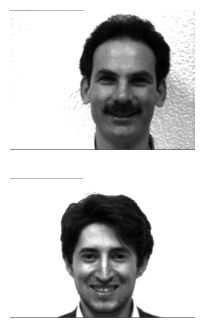

In [22]:
# Selection des images et creation de la matrice de donnees correspondante
indices_pers = [1,2] # On choisit l'individu 2 et 3
indices_post = [2] # les photos sur les quels ils sourient

nb_pers = len(indices_pers)
nb_post = len(indices_post)

# On definit les dimensions de X = X_orig_ACP matrice originelle que l'on va reconstruire avec ACP
m = nb_pers*nb_post # Nombre d'images selectionnees pour traitement (ici c'est 2)
n = 243*320 # Taille d'une image

X_orig_ACP = np.zeros((m,n))

# Les differents individus et postures dans le jeu de donnees
noms_pers = ['subject01','subject02','subject03','subject04','subject05','subject06','subject07','subject08',
            'subject09','subject10','subject11','subject12','subject13','subject14','subject15']
noms_post = ['centerlight','glasses','happy','leftlight','noglasses','normal','rightlight','sad','sleepy',
             'surprised','wink']

# On remplit la matrice X = X_orig_ACP et affiche les 2 images selectionnes
plt.figure(figsize=(3*nb_pers+1,3*nb_post+1))

for i in range(m):
    name_im = './sample_data/data/'+noms_pers[indices_pers[i//nb_post]]+'.'+noms_post[indices_post[i%nb_post]]
    img_array = plt.imread(name_im,format='gif')
    X_orig_ACP[i,:] = np.reshape(img_array,n)
    X_orig_ACP[i,:] = (1/255)*X_orig_ACP[i,:]

    plt.subplot(nb_pers,nb_post,i+1)
    plt.imshow(np.reshape(X_orig_ACP[i,:],(243,320)),cmap='gray')
    plt.axis('off')


In [23]:
# Stockage de la matrice (avec ACP)

# Calcul de l'individu moyen et de l'individu centre
ones_m = np.ones((m,1))
x_moyen = (1/m)*np.dot(np.transpose(X_orig_ACP),ones_m)
Xmoyen = np.matmul(ones_m,np.transpose(x_moyen))
X_c = X_orig_ACP-Xmoyen

# Calcul des valeurs propres de Sigma via Sigma_2, puisque de calculer et stocker Sigma est trop couteux
Sigma_2 = (1/(m-1))*np.dot(X_c,np.transpose(X_c))
l,v = np.linalg.eig(Sigma_2)

# Calcul des vecteurs propres correspondant aux valeurs propres non nulles (ou quasi-nulles) et de la matrice Eigfaces
lsort = np.argsort(l)
lsort = lsort[::-1]

V_2 = v[:,lsort[0:(m-1)]]
V = np.dot(np.transpose(X_c),V_2)
vnorms = norm(V,axis=0)
vnorms = 1/vnorms
Mvnorms = np.ones(V.shape)
for j in range(V.shape[1]):
    Mvnorms[:,j] = Mvnorms[:,j]*vnorms[j]

Eigfaces = np.dot(V,np.diag(vnorms))

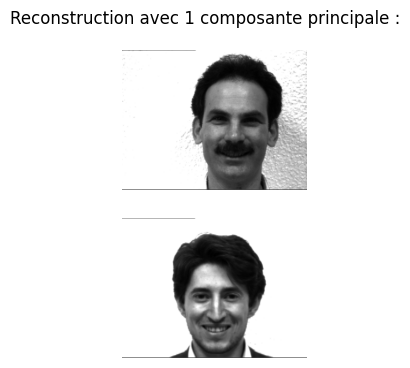

In [24]:
# Reconstruction des images (avec ACP)

qmax = 1 # Nombre max de composantes principales conservees

for q in range(qmax):
    Cp = np.matmul(X_c,Eigfaces[:,range(q+1)])
    X_rec_ACP = np.matmul(Cp,np.transpose(Eigfaces[:,range(q+1)])) + Xmoyen

    # On affiche les images obtenues
    plt.figure(figsize=(3*nb_pers + 1, 3*nb_post + 1))
    for j in range(m):
        plt.subplot(nb_pers,nb_post,j+1)
        plt.imshow(np.reshape(X_rec_ACP[j,:],(243,320)),cmap='gray')
        plt.axis('off')
    # Au plus on reconstruit avec une composante pricipale, puisque nous avons que 2 individus
    plt.suptitle('Reconstruction avec '+str(q+1)+' composante principale :')

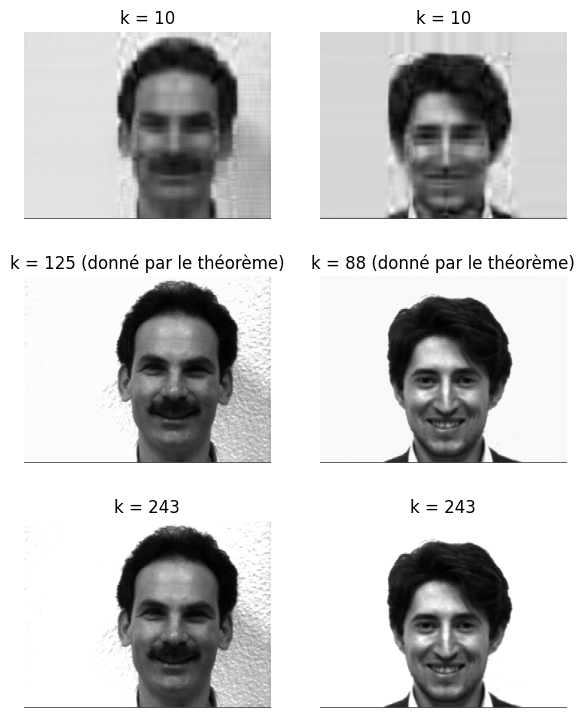

In [25]:
# Stockage et reconstruction de la matrice avec SVD

# On considere les deux images chaqu'une sous forme d'une matrice
n = 243
nombre_indivudus = 2

# Le nombre de valeurs de k que l'on va considerer (le nombre de valeurs singulieres que l'on va garder)
nombre_k = 3 # (c'est la longeur du tableau valeurs_k que l'on va definir plus tard)

# borne inf des valeurs singulieres qui elimine le maximum de bruit d'apres le theoreme de Gavish et Donoho
ceuil_sigma_k = 4 * sqrt(n)/sqrt(3)

X_orig_SVD = [] # On stocke les matrices initiales
X_rec_SVD = [] # On stocke les matrices reconstruites associes

plt.figure(figsize=(3*nombre_indivudus + 1, 3*nombre_k))

for j in range(nombre_indivudus):
    name_im = './sample_data/data/'+noms_pers[indices_pers[j//nb_post]]+'.'+noms_post[indices_post[j%nb_post]]
    X = plt.imread(name_im,format='gif')

    X_orig_SVD.append(X)
    u, s, v = np.linalg.svd(X) # Les valeurs singulieres sur la diagonale sont deja tries par ordre decroissant

    k = 0
    # On cherche le k qui elimine le maximum de bruit d'apres le theoreme
    for nb, sigma in enumerate(s.tolist()):
        if sigma < ceuil_sigma_k :
            k = nb
            break

    valeurs_k = [10, k, n] # valeurs de k possibles (k appartient entre 0 et n et represente le nombre de valeurs singuliers que l'on garde)

    for i, valeur_k in enumerate(valeurs_k):
        uk = u[:,:valeur_k]
        sk = np.diag(s[:valeur_k])
        vk = v[:valeur_k,:]

        plt.subplot(len(valeurs_k), nombre_indivudus, i * nombre_indivudus + j + 1)

        # On reconstruit et affiche les images obtenues
        Xk = uk @ sk @ vk
        plt.imshow(np.reshape(Xk,(243,320)),cmap='gray')

        if valeur_k == k:
          plt.title(f"k = {valeur_k} (donné par le théorème)")
          X_rec_SVD.append(Xk)
        else :
          plt.title(f"k = {valeur_k}")
        plt.axis('off')

### <span style="color:rgb(4, 154, 139)">a\)</span>

In [26]:
def norme_Frobenius(X_orig, X_rec):
  norme_F = 0
  for i in range(m):
    for j in range(n):
      norme_F += (X_rec[i][j] - X_orig[i][j])**2
  norme_F = sqrt(norme_F)
  return norme_F

print(f"Reconstruction en termes de norme de Frobenius avec ACP fournit une erreur de cette grandeur : {norme_Frobenius(X_orig_ACP, X_rec_ACP)}")

# Ici, nous avons plusieurs matrices X que l'on reconstruit separement
# et, pour evaluer l'erreur en termes de norme de Frobenius, on prend la moyenne de cette erreur pour chacune des matrices.
erreur_moyenne_SVD = 0
for i in range(len(X_rec_SVD)):
  erreur_moyenne_SVD += norme_Frobenius(X_orig_SVD[i], X_rec_SVD[i])
erreur_moyenne_SVD = erreur_moyenne_SVD/len(X_rec_SVD)

print(f"Reconstruction en termes de norme de Frobenius avec SVD fournit une erreur moyenne de cette grandeur : {erreur_moyenne_SVD}")

Reconstruction en termes de norme de Frobenius avec ACP fournit une erreur de cette grandeur : 2.220446049250313e-16
Reconstruction en termes de norme de Frobenius avec SVD fournit une erreur moyenne de cette grandeur : 9.143709839635658


Comme l’indiquent les calculs, la méthode par analyse en composantes principales (ACP) offre la meilleure reconstruction en termes de norme de Frobenius.

### <span style="color:rgb(4, 154, 139)">b\)</span>

Visuellement, nous n'observons pas de différences majeures entre les deux images; avec les deux méthodes, nous obtenons des images de suffisamment bonne qualité.

## <span style="color:rgb(255, 140, 0)">Question 2</span>

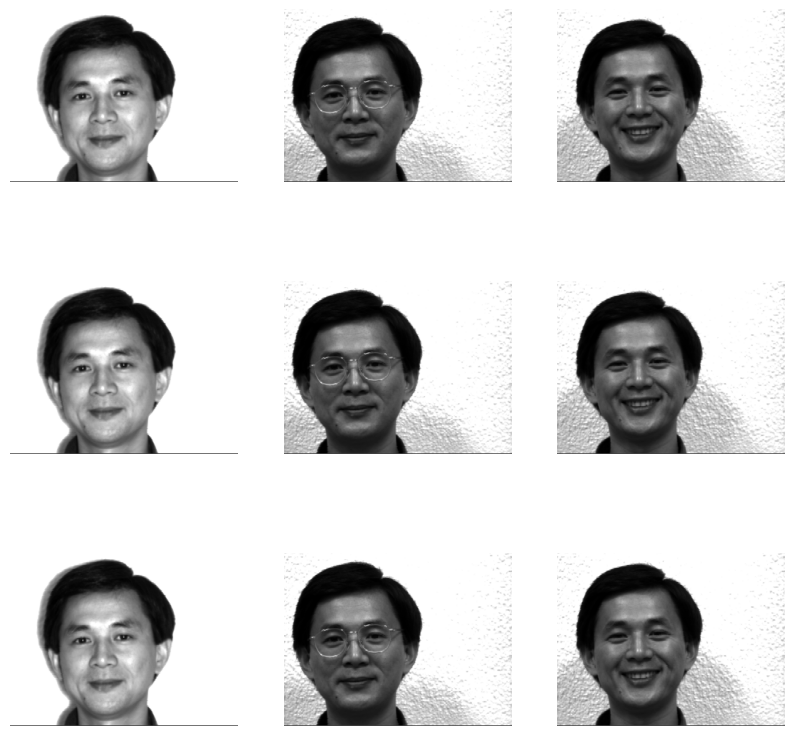

In [27]:
# On selectionne les 9 images de l'individu numero 6 avec les 3 premiers postures
indices_pers = [5 for i in range(3)]
indices_post = [i for i in range(3)]

nb_post = len(indices_post)
nb_pers = len(indices_pers)

# On definit les dimensions de X
m = nb_post*nb_pers
n = 243*320

X = np.zeros((m,n))

# On telecharge et affichage le sous-ensemble de donnees choisi
plt.figure(figsize=(3*nb_pers+1,3*nb_post+1))

for i in range(m):
    name_im = './sample_data/data/'+noms_pers[indices_pers[i//nb_post]]+'.'+noms_post[indices_post[i%nb_post]]
    img_array = plt.imread(name_im,format='gif')
    X[i,:] = np.reshape(img_array,n)
    X[i,:] = (1/255)*X[i,:]
    plt.subplot(nb_pers,nb_post,i+1)
    plt.imshow(np.reshape(X[i,:],(243,320)),cmap='gray')
    plt.axis('off')

In [28]:
# Stockage et reconstruction de la matrice avec ACP

# Calcul de l'individu moyen et de l'individu centre
ones_m = np.ones((m,1))
x_moyen = (1/m)*np.dot(np.transpose(X),ones_m)
Xmoyen = np.matmul(ones_m,np.transpose(x_moyen))
X_c = X-Xmoyen

# Calcul des valeurs propres de Sigma via Sigma_2 puisque de calculer et de manipuler directement Sigma est trop couteux

# Dans ce cas, nous avons que les 2 premieres valeurs propres sont non nulles ou non quasi nulles, puisque
# en centrant les individus, nous reduisons la dimension de 1, et le fait de prendre le meme individu 3 fois
# reduit egalement largement le rang de X_c.
Sigma_2 = (1/(m-1))*np.dot(X_c,np.transpose(X_c))
l,v = np.linalg.eig(Sigma_2)

# Calcul des vecteurs propres correspondant aux valeurs propres non nulles (ou quasi-nulles) et de la matrice Eigfaces

lsort = np.argsort(l)
lsort = lsort[::-1]

V_2 = v[:,lsort[0:2]]
V = np.dot(np.transpose(X_c),V_2)
vnorms = norm(V,axis=0)
vnorms = 1/vnorms
Mvnorms = np.ones(V.shape)
for j in range(V.shape[1]):
    Mvnorms[:,j] = Mvnorms[:,j]*vnorms[j]

Eigfaces = np.dot(V,np.diag(vnorms))

### <span style="color:rgb(4, 154, 139)">a\)</span>

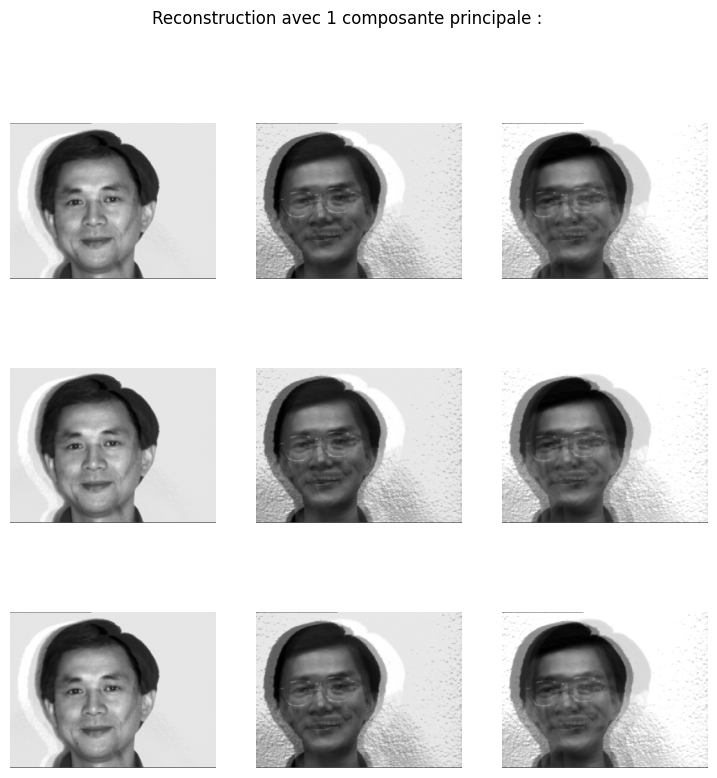

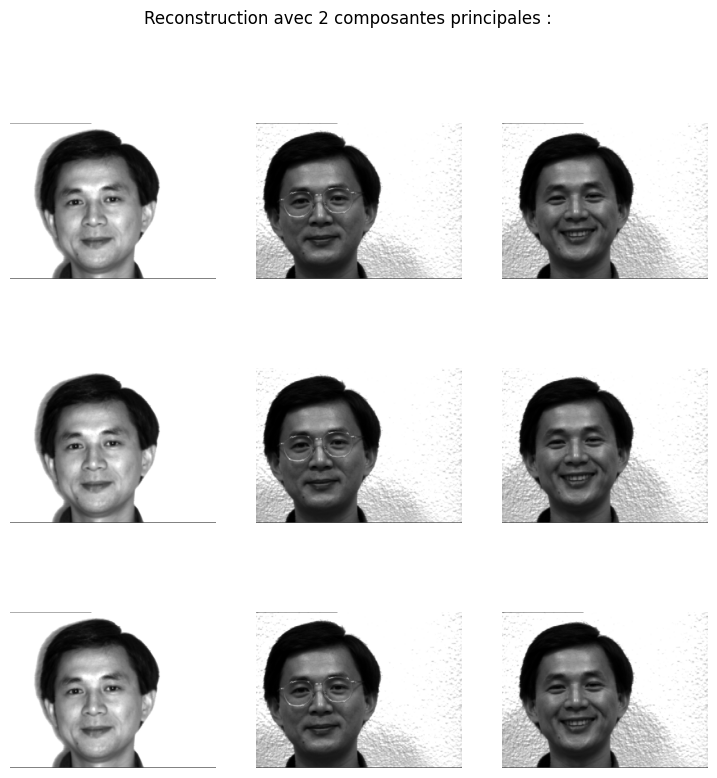

In [29]:
# Reconstruction des images a partir des composantes principales

qmax = 2 #Nombre max de composantes principales conservees

for q in range(qmax):
    Cp = np.matmul(X_c,Eigfaces[:,range(q+1)])
    Xrec = np.matmul(Cp,np.transpose(Eigfaces[:,range(q+1)]))+Xmoyen
    Xrec = np.real(Xrec) # Pour pouvoir afficher les images, nous avons besoin du fait que les coefficients soient reelles

    plt.figure(figsize=(3*nb_pers,3*nb_post))
    for j in range(m):
        plt.subplot(nb_pers,nb_post,j+1)
        plt.imshow(np.reshape(Xrec[j,:],(243,320)),cmap='gray')
        plt.axis('off')
    if q>0:
        plt.suptitle('Reconstruction avec '+str(q+1)+' composantes principales :',fontsize=12)
    else:
        plt.suptitle('Reconstruction avec '+str(q+1)+' composante principale :',fontsize=12)

Oui, la reconstruction des individus est meilleure avec cet ensemble. À partir de 2 composantes principales, nous observons des images (quasi) exactes, sauf qu'il n'est pas très intéressant d'avoir une matrice avec le même individu répété.

### <span style="color:rgb(4, 154, 139)">b\)</span>

(-0.5, 319.5, 242.5, -0.5)

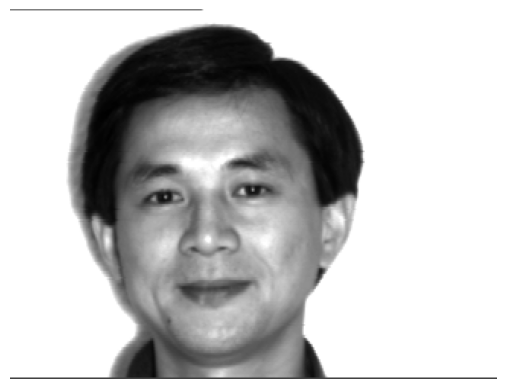

In [30]:
# Reconnaissance de visages via ACP avec la meme personne

# On recupere une image de la meme personne
ipers = indices_pers[0]
ipost = 0
name_im = './sample_data/data/'+noms_pers[ipers]+'.'+noms_post[ipost]

# On affiche cette image
img_array = plt.imread(name_im,format='gif')
x_plus = np.reshape(img_array,(n,1))
plt.imshow(np.reshape(x_plus,(243,320)),cmap='gray')
plt.axis('off')

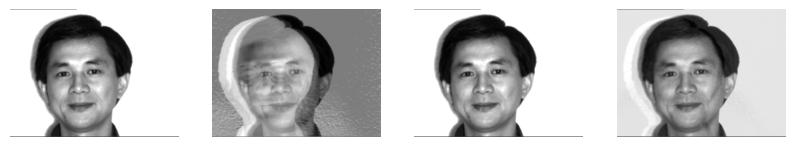

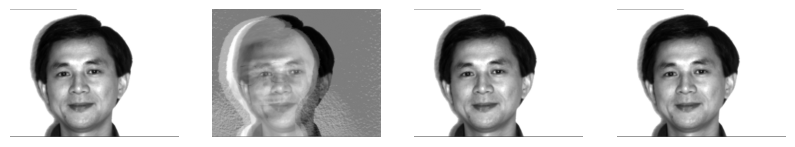

In [31]:
# On calcule les composantes principales de X et x_plus (notre nouvelle image) et ensuite les reconstructions correspondantes

for q in range(qmax):
    Cp = np.matmul(X_c,Eigfaces[:,range(q+1)])
    cplus = np.matmul(np.transpose(x_plus-x_moyen),Eigfaces[:,range(q+1)])
    Xrec = np.matmul(Cp,np.transpose(Eigfaces[:,range(q+1)]))+Xmoyen
    Xrec = np.real(Xrec) # Nous avons besoin que les coefficients soient reels
    xrec_plus = np.matmul(Eigfaces[:,range(q+1)],np.transpose(cplus)) + x_moyen
    xrec_plus = np.real(xrec_plus) # Nous avons besoin que les coefficients soient reels
    # On calcule l'image la plus proche de la nouvelle image au sens des composantes principales
    DiffC = Cp-np.dot(ones_m,cplus)
    h = norm(DiffC,axis=1)
    iq = np.argmin(h)

    # On affiche les deux images et leur reconstruction
    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(np.reshape(x_plus,(243,320)),cmap='gray')
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(np.reshape(xrec_plus,(243,320)),cmap='gray')
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(np.reshape(X[iq,:],(243,320)),cmap='gray')
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(np.reshape(Xrec[iq,:],(243,320)),cmap='gray')
    plt.axis('off')

On remarque que même avec qu'une composante principale, l'image est directement reconnue.

(-0.5, 319.5, 242.5, -0.5)

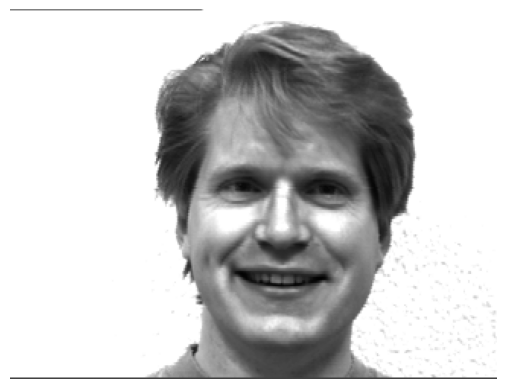

In [32]:
# Reconnaissance de visages via ACP avec une personne differente

# On recupere une image d'une des personnes ne faisant pas partie de notre base de donnees
ipers = 0
ipost = 2
name_im = './sample_data/data/'+noms_pers[ipers]+'.'+noms_post[ipost]

# On affiche cette image
img_array = plt.imread(name_im,format='gif')
x_plus = np.reshape(img_array,(n,1))
plt.imshow(np.reshape(x_plus,(243,320)),cmap='gray')
plt.axis('off')

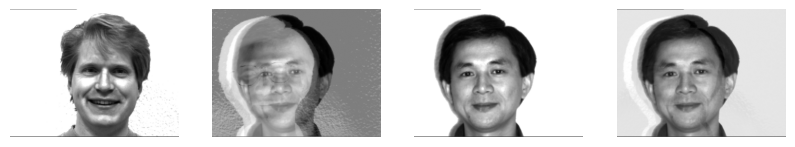

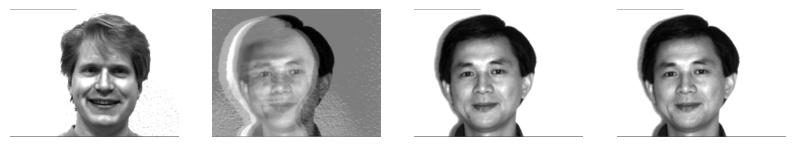

In [33]:
# On effectue les memes etapes que precedemment
for q in range(qmax):
    Cp = np.matmul(X_c,Eigfaces[:,range(q+1)])
    cplus = np.matmul(np.transpose(x_plus-x_moyen),Eigfaces[:,range(q+1)])
    Xrec = np.matmul(Cp,np.transpose(Eigfaces[:,range(q+1)]))+Xmoyen
    Xrec = np.real(Xrec)
    xrec_plus = np.matmul(Eigfaces[:,range(q+1)],np.transpose(cplus)) + x_moyen
    xrec_plus = np.real(xrec_plus)

    DiffC = Cp-np.dot(ones_m,cplus)
    h = norm(DiffC,axis=1)
    iq = np.argmin(h)

    # On affiche les deux images ainsi que leur reconstruction
    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(np.reshape(x_plus,(243,320)),cmap='gray')
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(np.reshape(xrec_plus,(243,320)),cmap='gray')
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(np.reshape(X[iq,:],(243,320)),cmap='gray')
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(np.reshape(Xrec[iq,:],(243,320)),cmap='gray')
    plt.axis('off')

Ici, bien évidemment, nous n'avons pas réussi à trouver la personne exacte, mais nous avons obtenu l'image la plus proche en termes de composantes principales.

# <span style="color:rgb(4,139,154)">Partie 2 : Régression linéaire</span>

## <span style="color:rgb(255, 140, 0)">Question 3</span>

In [34]:
# Génération des données

np.random.default_rng()

n=40
m=10

# La vérité terrain est générée avec des coefficients décroissants
idx = np.arange(n)
beta_star = (-1)**idx * np.exp(-idx / 10.)

# La génération de X se fait de manière aléatoire
corr = 0.5
X = multivariate_normal(np.zeros(n), toeplitz(corr ** np.arange(0, n)), size=m)
y = X.dot(beta_star) #Tendance lineaire veritable


lbda=6



### <span style="color:rgb(4, 154, 139)">a\)</span>

In [35]:
sigma=1
eps = normal(0,sigma,size=m)
y_noise = y+eps

betaMV = pinv(X).dot(y_noise)
betaMAP = inv(X.T @ X + lbda * (sigma ** 2) * np.eye(n)).dot(X.T.dot(y_noise))

print('Erreur sans a priori : ', norm(betaMV-beta_star))
print('Erreur avec a priori : ', norm(betaMAP-beta_star))

Erreur sans a priori :  2.347987073412734
Erreur avec a priori :  2.290218224904667


Après avoir modifié les dimensions des données avec n=40 et m=10, on observe que les deux erreurs (avec et sans a priori) ont augmenté par rapport à la configuration initiale.

Évolution des erreurs :
Dans la configuration précédente, les erreurs étaient toutes deux en dessous de la barre de 1, mais avec les nouvelles dimensions, elles ont dépassé cette valeur. Cela s'explique par la réduction de la taille des données (spécifiquement m), ce qui rend les estimations moins précises.

Différence entre les deux estimateurs :
Malgré l'augmentation des erreurs globales, la différence entre les erreurs des deux méthodes reste très faible, inférieure à 0.004. Cela montre que l'utilisation d'un a priori n'apporte qu'une amélioration marginale dans ce cas précis, probablement en raison de la faible valeur de sigma.

### <span style="color:rgb(4, 154, 139)">b\)</span>

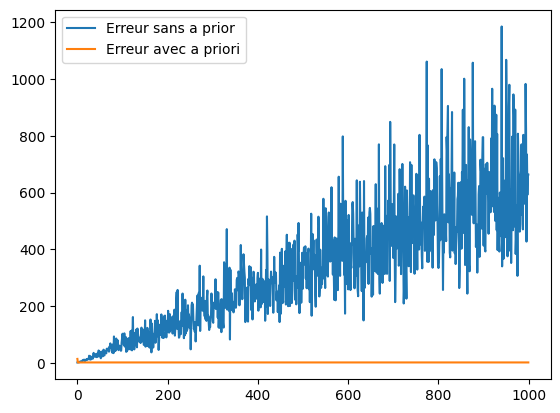

In [36]:
echantillon_sigma = [i for i in range(1000)]

erreur_sans_a_priori = []
erreur_a_priori = []


for sigma in echantillon_sigma:
    eps = normal(0, sigma, size=m)
    y_noise = y + eps

    betaMV = pinv(X).dot(y_noise)
    betaMAP = inv(X.T @ X + lbda * (sigma ** 2) * np.eye(n)).dot(X.T.dot(y_noise))

    erreur_sans_a_priori.append(norm(betaMV - beta_star))
    erreur_a_priori.append(norm(betaMAP-beta_star))

plt.figure()
plt.plot(echantillon_sigma, erreur_sans_a_priori, label = 'Erreur sans a prior')
plt.plot(echantillon_sigma, erreur_a_priori, label = 'Erreur avec a priori')
plt.legend()
plt.show()

En observant les résultats obtenus et la courbe associée, on constate que l'évolution de l'erreur est significativement influencée par la valeur du paramètre σ. Plus précisément :

Erreur sans a priori :
L'erreur sans a priori augmente de manière considérable avec l'augmentation de σ. Cela s'explique par le fait que des valeurs élevées de σ introduisent davantage de bruit dans les données, rendant la tâche d'estimation ou de prédiction plus difficile en l'absence d'une régularisation ou d'informations supplémentaires.

Erreur avec a priori :
Contrairement à la situation sans a priori, l'erreur avec a priori reste relativement stable même lorsque σ augmente. Cela montre que l'intégration d'un a priori permet de limiter l'impact du bruit sur les performances du modèle.

## <span style="color:rgb(255, 140, 0)">Question 4</span>

In [37]:
def bezier(t,d,beta_0,beta,beta_d):

    c = beta_0*((1-t)**d)
    c = c + beta_d*(t**d)

    if d>1:
        for i in range(1,d):
            c = c+beta[i-1]*comb(d,i)*(t**i)*((1-t)**(d-i))

    return c

def estimbeta(X,y,beta_0,beta_d):
    d =X.shape[1]-1
    y = y - beta_0*X[:,0] - beta_d*X[:,d]
    A = np.linalg.pinv(X[:,1:d])
    beta = np.dot(A,y)

    return beta

def bernstein(t,d):

    X = np.zeros((t.shape[0],d+1))
    for i in range(0,d+1):
        X[:,i] = comb(d,i)*(t**i)*((1-t)**(d-i))

    return X

### <span style="color:rgb(4, 154, 139)">a\)</span>

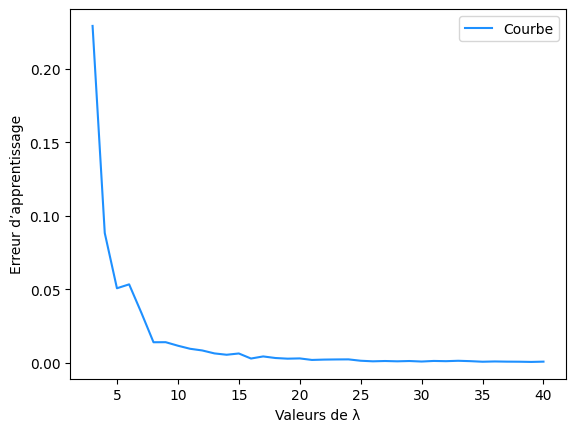

In [38]:
d_star=5
n=40
m_max = 40

beta_0 = 115
beta_star = np.array([133,96,139,118])
beta_dstar = 123

t = np.linspace(0,1,n)
c = bezier(t,d_star,beta_0,beta_star,beta_dstar)
X = bernstein(t, d_star)

sigma_liste=[1/k for k in range(2,m_max)]
erreur_liste = []

for sigma in sigma_liste:
    eps = np.random.normal(0,sigma,n)
    y = c+np.array(eps)
    b = estimbeta(X,y,beta_0,beta_dstar)
    b = np.concatenate([[beta_0], b, [beta_dstar]])

    erreur_liste.append((1/n)*norm(np.dot(X,b)-y)**2)

plt.figure()
plt.plot([k for k in range(m_max,2,-1)],erreur_liste[::-1],color='dodgerblue',label='Courbe')
plt.xlabel('Valeurs de λ')
plt.ylabel('Erreur d’apprentissage')
plt.legend()
plt.show()




Lorsque la dimension du problème est finie (ici 5), on remarque que l’erreur d’apprentissage diminue à mesure que la valeur de λ (le paramètre de régularisation) augmente.

### <span style="color:rgb(4, 154, 139)">b\)</span>

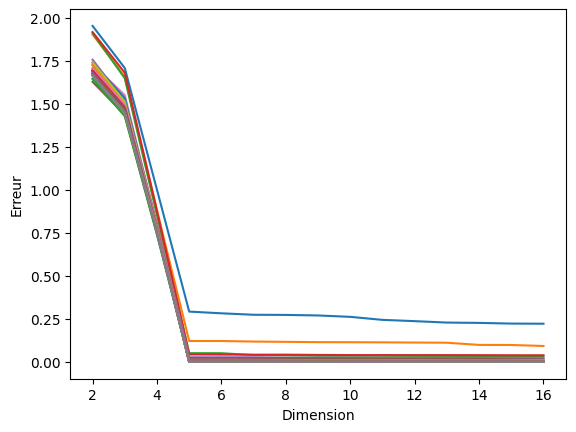

In [39]:
for sigma in sigma_liste:
    eps = np.random.normal(0,sigma,n)
    y = c+np.array(eps)
    dvals = np.arange(2,17) # Valeurs possibles pour d
    n_dvals = dvals.shape[0]
    e = np.zeros(n_dvals)

    for i_d in range(0,n_dvals):

        b = np.zeros(dvals[i_d]+1) # NB : On doit changer la taille de b a chaque iteration
        b[0] = beta_0
        b[dvals[i_d]] = beta_dstar
        # Former la matrice X et calculer l'estimation de beta
        X = bernstein(t,dvals[i_d])
        beta_est = estimbeta(X,y,beta_0,beta_dstar)
        # Calculer l'erreur d'apprentissage
        b[1:dvals[i_d]] = beta_est
        e[i_d] = (1/n)*norm(np.dot(X,b)-y)**2 # Normalisation de e, pas indispensable mais frequente en pratique

    plt.plot(dvals,e)  #on affiche les différentes courbes d'erreurs en fonction des dimensions et des lambdas
    plt.xlabel('Dimension')
    plt.ylabel('Erreur')

plt.show()


Le graphique ci-dessus illustre les différentes courbes d'erreur en fonction des dimensions, chaque courbe correspondant à une valeur spécifique de λ. On observe que toutes les courbes suivent une tendance similaire, et que l'erreur se stabilise à partir de la dimension 5. Cela indique que, quel que soit le bruit gaussien ajouté au modèle (avec une variance 1/λ), la dimension optimale reste inchangée. Dans cet exemple, la dimension optimale est donc 5.

L'ajout de ce bruit gaussien joue un rôle proche de celui d'une régularisation, car il empêche le modèle de s'ajuster excessivement aux données d'apprentissage, ce qui réduit ainsi le risque de surapprentissage (overfitting). En d'autres termes, cela améliore la capacité du modèle à généraliser sur des données non vues.